In [47]:
from typing import Annotated, TypedDict, List
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import display, Markdown, Image
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.agents import Tool
import json
import uuid

import random
import gradio as gr

load_dotenv()

True

In [48]:
llm = ChatOpenAI(model="gpt-4o-mini")
system_prompt = """
    You are a medical assistant. Based on the user message, you will decide whether to response normally or to look for information
    in the medical documents provided. When relevant be sure to look into the documents to provide accurate information. 
    """
prompt = ChatPromptTemplate.from_messages([
    SystemMessage(content=system_prompt),
    MessagesPlaceholder(variable_name="messages")
    ])

chain = prompt | llm

In [49]:
class State(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]

In [50]:
def log_messages(messages: List[BaseMessage]) -> None:
    for message in messages:
        if isinstance(message, HumanMessage):
            print(f"Human: {message.content}")
        elif isinstance(message, AIMessage):
            print(f"AI: {message.content}")
        elif isinstance(message, SystemMessage):
            print(f"System: {message.content}")

In [54]:
def advisor_node(old_state: State) -> State:
    response = chain.invoke(old_state["messages"])
    print("________________________")
    print(log_messages(old_state["messages"] + [response]))
    return {"messages": [response]}

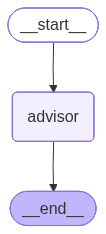

In [55]:
graph_builder = StateGraph(State)

graph_builder.add_node("advisor", advisor_node)
graph_builder.add_edge(START, "advisor")
graph_builder.add_edge("advisor", END)

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
def make_thread_id() -> str:
    return str(uuid.uuid4())

config = {"configurable": {"thread_id": make_thread_id()}}

def chat(user_message, history):
    out = graph.invoke({"messages": [HumanMessage(content=user_message)]}, config=config)
    return out["messages"][-1].content

gr.ChatInterface(fn=chat, title="LangGraph LLM Test").launch()

/mnt/d/Work/Projects/AI-Engineer/medical-reports/.venv/lib/python3.12/site-packages/gradio/chat_interface.py:348: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


* Running on local URL:  http://127.0.0.1:7868
* To create a public link, set `share=True` in `launch()`.


________________________
Human: what r u
AI: I am a medical assistant here to help you with your medical questions or concerns. How can I assist you today?
None
